# Lecture 2 - Confounding and Randomized versus Non-randomized Studies

## Today's Learning Objectives

1. Define the Simpson's paradox.
2. Illustrate the Simpson's paradox occurrence via simulated and real data.
3. Provide a basic guideline to avoid the Simpson's paradox.
4. Provide a definition of a confounding variable.
5. Argue why evidence from a randomized study is of a higher grade than evidence from an observational study.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8)
library(tidyverse)
library(infer)
library(broom)
library(cowplot)
library(bayestestR)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp




## 1. Simpson's Paradox

We have seen the benefits of making an appropriate and thoughtful exploratory data analysis (EDA) throughout the statistical courses. EDA allows you to detect graphical trends in the data that could be confirmed at a statistical level via a suitable model. Nevertheless, what are the implications of a **limited and poor EDA**?

Limitations in an EDA can lead to misleading graphical conclusions that have the potential to bias our data modelling, which will also lead to deceptive statistical conclusions! Simpson's paradox basically arises **when we have a poor EDA and data modelling**. 

```{important}
**Simpson's paradox occurs when we see a trend in aggregated data (between two variables $X$ and $Y$), but this trend reverses when we separate the data into specific groups (i.e., we take into account another variable $Z$).** It was first addressed by Edward Simpson in 1951 in his paper "[The Interpretation of Interaction in Contingency Tables](http://math.bme.hu/~marib/bsmeur/simpson.pdf)."
```

### 1.1.  A Simulated Example

The package `bayestestR` offers a useful function to simulate data so we can graphically understand the Simpson's paradox. The function `simulate_simpson()` simulates some data coming from four `groups` of size `200` each where the within-group **positive linear correlation** is `0.4`. The two **continuous** variables of interest are $X$ and $Y$.

In [2]:
set.seed(554) # Reproducibility

simpson_data <- simulate_simpson(
  n = 200,
  groups = 4,
  r = 0.4,
  group_prefix = "Group "
)

colnames(simpson_data) <- c("X", "Y", "Group")
simpson_data

X,Y,Group
<dbl>,<dbl>,<chr>
0.301913,-1.3353848,Group 1
1.973782,-0.9160513,Group 1
1.113595,-1.7805183,Group 1
2.872386,0.6106858,Group 1
⋮,⋮,⋮
5.569538,-2.856632,Group 4
3.394598,-4.470594,Group 4
3.751953,-4.837983,Group 4
3.898065,-2.540426,Group 4


Let us start with a **naive EDA** where we do not use `Group` and just create a scatterplot of $X$ versus $Y$. Moreover, suppose you want to statistically assess whether $X$ is linearly associated with $Y$ and how.

In [3]:
options(repr.plot.height = 8, repr.plot.width = 14)

naive_EDA <- ggplot(simpson_data, aes(x = X, y = Y)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, formula = y ~ x, colour = "red") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.title = element_text(size = 21), 
    legend.text = element_text(size = 17)
  ) +
  ggtitle("Aggregated Scatterplot of X versus Y")

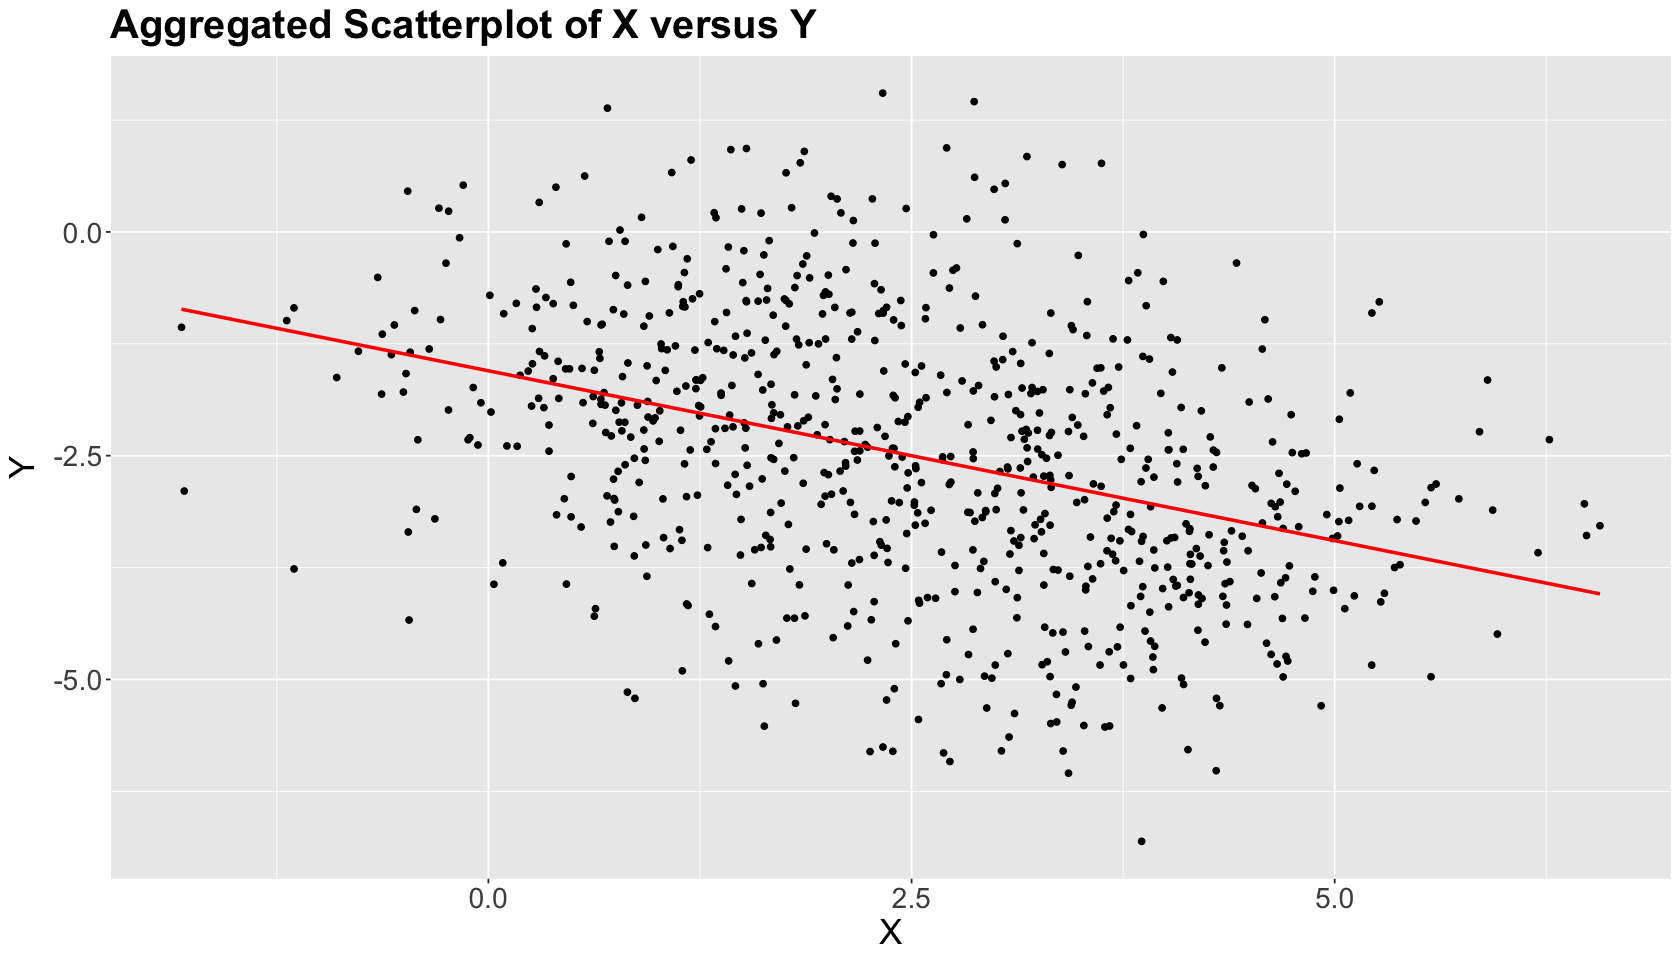

In [4]:
naive_EDA

Note there is an **overall negative** graphical relation between $X$ and $Y$, which is confirmed by a linear correlation coefficient $\rho = -0.38$ (see the below code). Also, the ordinary least-squares (OLS) estimated red line statistically confirms this trend.

In [5]:
round(cor(simpson_data$X, simpson_data$Y), 2)

[1] -0.38

Let us be more clever in our EDA and **consider `Group`** in another scatterplot along with $X$ and $Y$. This scatterplot now shows upward trends within the groups! Moreover, as previously specified, the within-group linear correlation $\rho = 0.4$ (the opposite from the aggregated negative correlation).

In [6]:
simpson_data %>% group_by(Group) %>%
  summarise(corr = round(cor(X, Y), 2))

Group,corr
<chr>,<dbl>
Group 1,0.4
Group 2,0.4
Group 3,0.4
Group 4,0.4


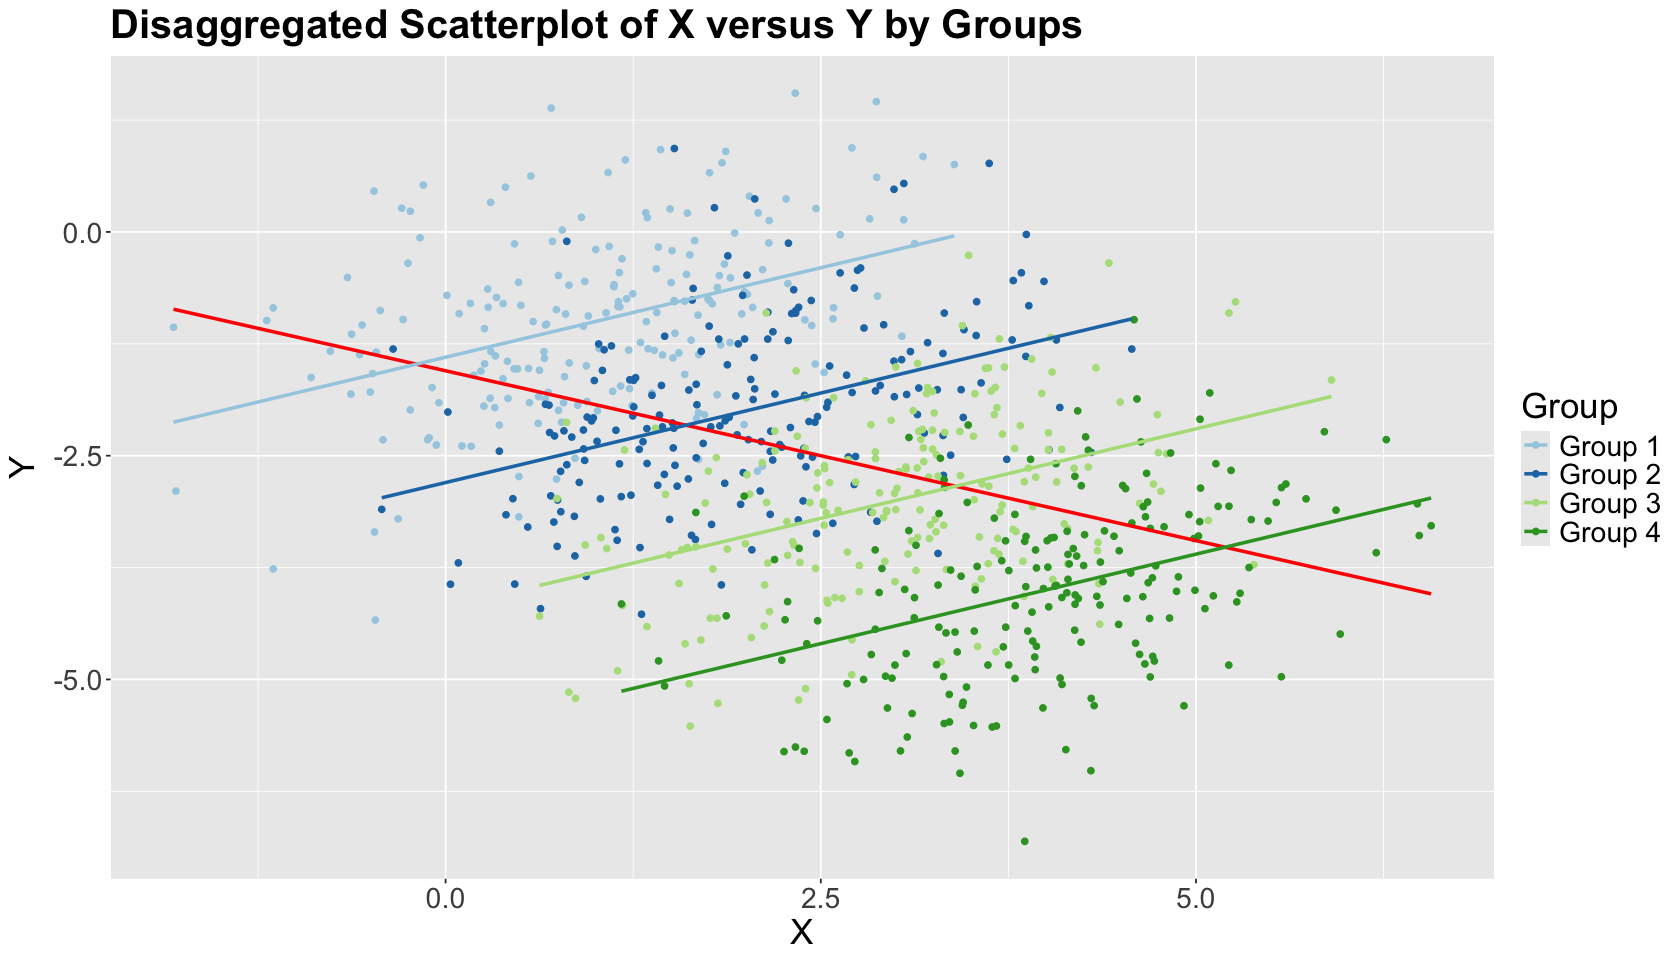

In [7]:
clever_EDA <- ggplot(simpson_data, aes(x = X, y = Y)) +
  geom_point(aes(color = Group)) +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE, colour = "red") +
  geom_smooth(aes(color = Group), method = "lm", formula = y ~ x, se = FALSE) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.title = element_text(size = 21), 
    legend.text = element_text(size = 17)
  ) +
  ggtitle("Disaggregated Scatterplot of X versus Y by Groups") +
  scale_colour_brewer(palette = "Paired")

clever_EDA

The within-group estimated OLS lines have positive slopes, unlike the overall OLS estimated blue line. This is the Simpson's paradox in action! 

```{admonition}  What is the main takeaway?
:class: hint
This toy example shows us why taking into account the right variables in our studies is critical in any association or causal analysis. Now, let us check a real example involving one continuous variable of interest $Y$, a categorical $X$, and another categorical $Z$.
```

### 1.2.  A COVID-19 Example

This case comes from the work by [Kügelgen et al. (2021)](https://www.computer.org/csdl/journal/ai/2021/01/09404149/1sNm718j25W). The authors point out the Simpson's paradox when comparing **aggregated case fatality rates** between two **countries**: China and Italy. But, then, the data trends reverse once they control by **age groups**. This is data from the earlier pandemic months (February 2020 for China and March 2020 for Italy). The original dataset has more countries.

Firstly, let us define the continuous **case fatality rate**:

$$\text{Case Fatality Rate} = \frac{\text{Confirmed Fatalities}}{\text{Confirmed Cases}}.$$

Then, we check the data frames by country. Note data is aggregated by **nine age groups**.

In [8]:
covid19_data_china <-
  read_csv("../data/Covid-19_age-stratified_dataset_for_different_countries.csv", show_col_types = FALSE) %>%
  filter(Country == "China") %>%
  mutate(`Fatality rate` = `Confirmed fatalities` / `Confirmed cases`)

covid19_data_italy <-
  read_csv("../data/Covid-19_age-stratified_dataset_for_Italy_at_different_points_in_time.csv", show_col_types = FALSE) %>% 
  filter( `Date of reporting` == "9 March2020" ) %>% 
  mutate(`Fatality rate` = `Confirmed fatalities` /  `Confirmed cases`)

New names:
• `` -> `...1`


New names:
• `` -> `...1`


In [9]:
covid19_data_china

...1,Country,Date of reporting,Age group,Confirmed cases,Confirmed fatalities,Fatality rate
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
9,China,17 February2020,0-9,416,0,0.000000000
10,China,17 February2020,10-19,549,1,0.001821494
11,China,17 February2020,20-29,3619,7,0.001934236
12,China,17 February2020,30-39,7600,18,0.002368421
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,China,17 February2020,50-59,10008,130,0.01298961
15,China,17 February2020,60-69,8583,309,0.03600140
16,China,17 February2020,70-79,3918,312,0.07963247
17,China,17 February2020,80+,1408,208,0.14772727


In [10]:
covid19_data_italy

...1,Country,Date of reporting,Age group,Confirmed cases,Confirmed fatalities,Fatality rate
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
0,Italy,9 March2020,0-9,43,0,0
1,Italy,9 March2020,10-19,85,0,0
2,Italy,9 March2020,20-29,296,0,0
3,Italy,9 March2020,30-39,470,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,Italy,9 March2020,50-59,1453,3,0.002064694
6,Italy,9 March2020,60-69,1471,37,0.025152957
7,Italy,9 March2020,70-79,1785,114,0.063865546
8,Italy,9 March2020,80+,1532,202,0.131853786


Then, let us combine both data frames.

In [11]:
covid19_data <- bind_rows(covid19_data_china, covid19_data_italy)
covid19_data

...1,Country,Date of reporting,Age group,Confirmed cases,Confirmed fatalities,Fatality rate
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
9,China,17 February2020,0-9,416,0,0.000000000
10,China,17 February2020,10-19,549,1,0.001821494
11,China,17 February2020,20-29,3619,7,0.001934236
12,China,17 February2020,30-39,7600,18,0.002368421
⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,Italy,9 March2020,50-59,1453,3,0.002064694
6,Italy,9 March2020,60-69,1471,37,0.025152957
7,Italy,9 March2020,70-79,1785,114,0.063865546
8,Italy,9 March2020,80+,1532,202,0.131853786


The data does not have the aggregated case fatality rates by country. So let us compute them and bind them to `covid19_data`.

In [12]:
covid19_data_agg_by_country <- covid19_data %>%
  group_by(`Country`) %>%
  summarise(
    `Confirmed fatalities` = sum(`Confirmed fatalities`),
    `Confirmed cases` = sum(`Confirmed cases`)
  ) %>%
  mutate(
    `Fatality rate` = `Confirmed fatalities` / `Confirmed cases`,
    `Age group` = "Total"
  )
covid19_data_agg_by_country

Country,Confirmed fatalities,Confirmed cases,Fatality rate,Age group
<chr>,<dbl>,<dbl>,<dbl>,<chr>
China,1023,44672,0.02290025,Total
Italy,357,8026,0.04448044,Total


In [13]:
covid19_data <- bind_rows(covid19_data, covid19_data_agg_by_country) %>% 
  mutate(`Age group` = as.factor(`Age group`))
covid19_data

...1,Country,Date of reporting,Age group,Confirmed cases,Confirmed fatalities,Fatality rate
<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
9,China,17 February2020,0-9,416,0,0.000000000
10,China,17 February2020,10-19,549,1,0.001821494
11,China,17 February2020,20-29,3619,7,0.001934236
12,China,17 February2020,30-39,7600,18,0.002368421
⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,Italy,9 March2020,70-79,1785,114,0.06386555
8,Italy,9 March2020,80+,1532,202,0.13185379
NA,China,NA,Total,44672,1023,0.02290025
NA,Italy,NA,Total,8026,357,0.04448044


Then, we plot this case fatality rates by country in a histogram. The **overall** case fatality rate was considerably lower in China than in Italy. This, of course, ignores the many challenging questions about estimating (and reporting!) the true number of COVID-19 cases.

In [14]:
hist_covid19_fatality_by_country <- filter(covid19_data, `Age group` == "Total") %>%
  ggplot(aes(x = `Age group`, y = `Fatality rate`, fill = `Country`)) +
  geom_bar(position = "dodge", stat = "identity") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    axis.title.x = element_blank(),
    legend.title = element_text(size = 21), 
    legend.text = element_text(size = 17)
  ) +
  ggtitle("Overall Case Fatality Rates by Country") +
  ylab("Case Fatality Rate") +
  scale_fill_brewer(palette = "Paired")

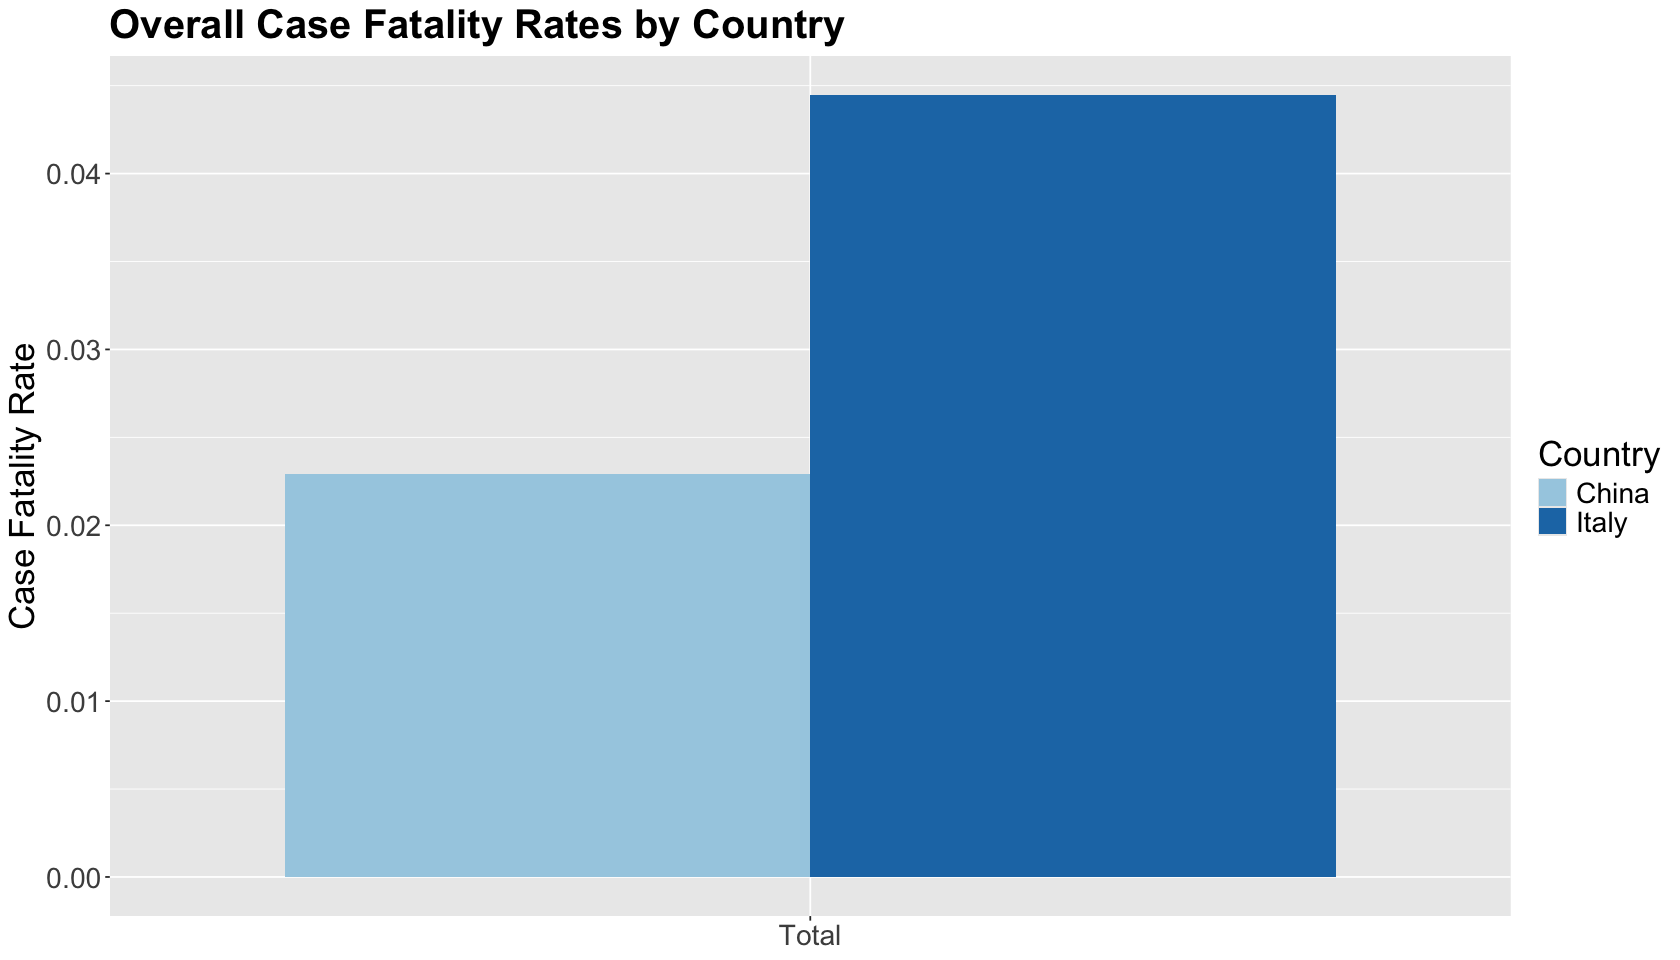

In [15]:
hist_covid19_fatality_by_country

Let us dig into this a little bit by age group. At **each age group**, the case fatality rate in Italy was lower than in China. **The trend flips compared to the overall case fatality rates!**

In [16]:
hist_covid19_fatality_by_country_and_age <- filter(covid19_data, `Age group` != "Total") %>%
  ggplot(aes(x = `Age group`, y = `Fatality rate`, fill = `Country`)) +
  geom_bar(position = "dodge", stat = "identity") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    axis.title.x = element_blank(),
    legend.title = element_text(size = 21), 
    legend.text = element_text(size = 17)
  ) +
  ggtitle("Case Fatality Rates by Country and Age") +
  ylab("Case Fatality Rate") +
  xlab("Age Group") +
  scale_fill_brewer(palette = "Paired")

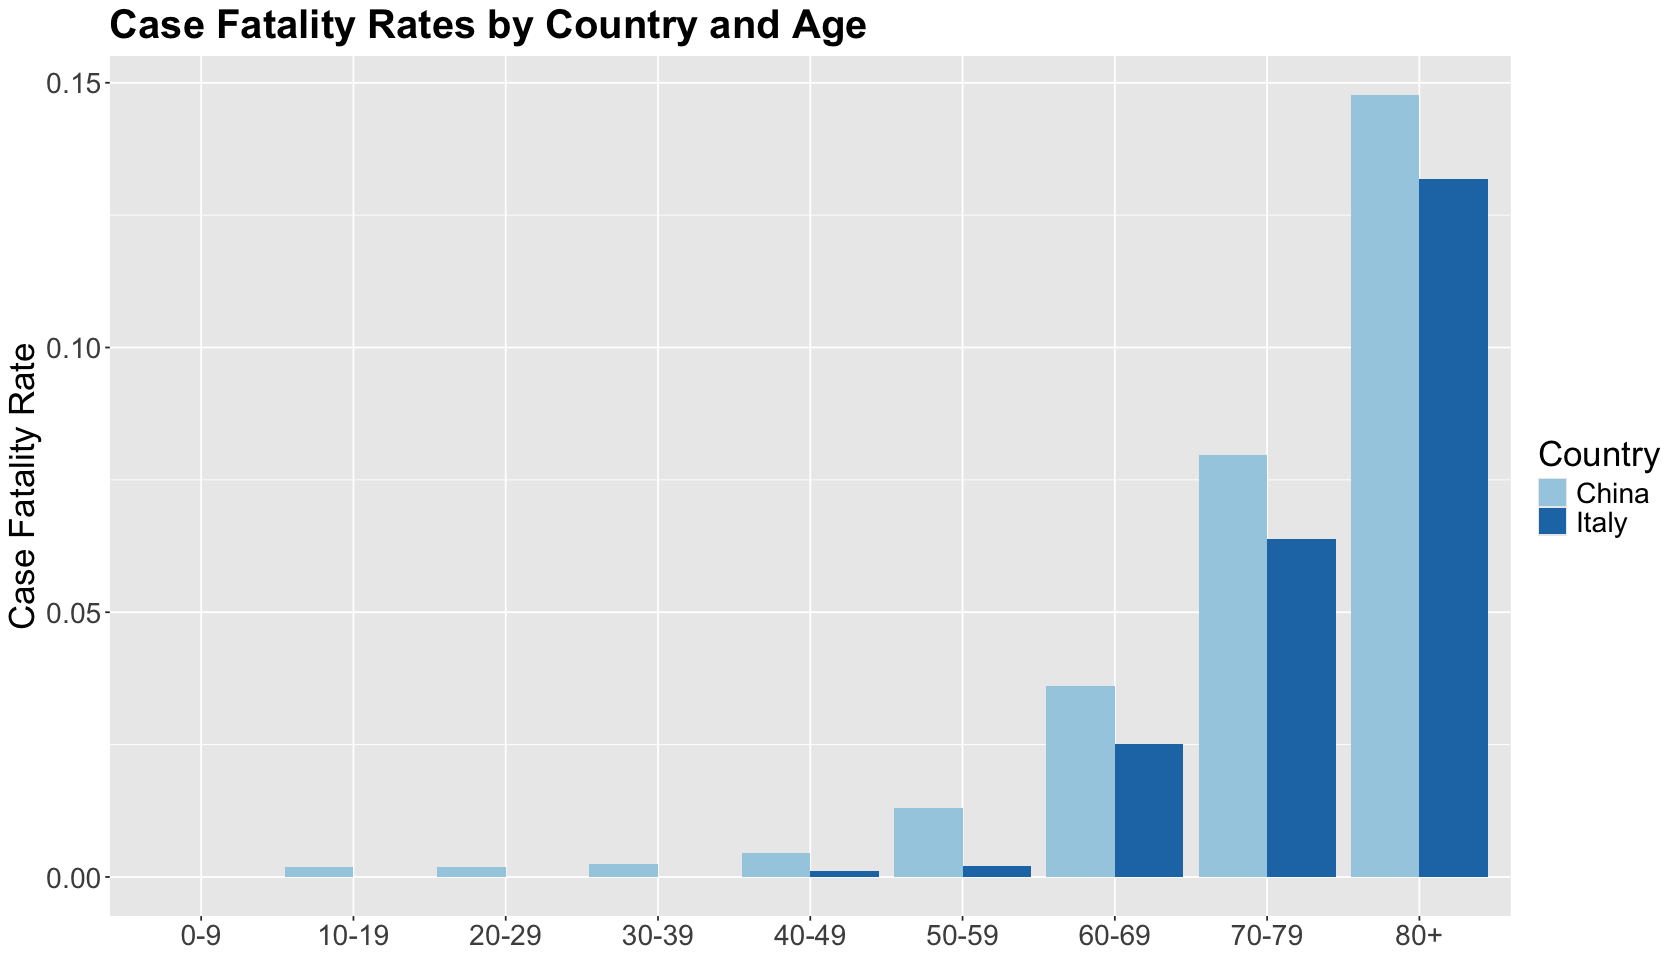

In [17]:
hist_covid19_fatality_by_country_and_age

**This is contradictory! What is happening here?** We will obtain the proportion of cases by age group to the total sum by country to answer this.

In [18]:
covid19_data_perc_by_country_and_age <- filter(covid19_data, `Age group` != "Total") %>%
  group_by(`Country`) %>%
  mutate(`Proportion of cases` = `Confirmed cases` / sum(`Confirmed cases`))
covid19_data_perc_by_country_and_age

...1,Country,Date of reporting,Age group,Confirmed cases,Confirmed fatalities,Fatality rate,Proportion of cases
<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
9,China,17 February2020,0-9,416,0,0.000000000,0.009312321
10,China,17 February2020,10-19,549,1,0.001821494,0.012289577
11,China,17 February2020,20-29,3619,7,0.001934236,0.081012715
12,China,17 February2020,30-39,7600,18,0.002368421,0.170128940
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,Italy,9 March2020,50-59,1453,3,0.002064694,0.1810366
6,Italy,9 March2020,60-69,1471,37,0.025152957,0.1832793
7,Italy,9 March2020,70-79,1785,114,0.063865546,0.2224022
8,Italy,9 March2020,80+,1532,202,0.131853786,0.1908796


Once we plot the percentage of confirmed cases by age group and country (**bars of the same color add up to 1**), we can see that the cases in Italy are more skewed to older age groups, unlike the cases in China, which are more centred around the 50s.

In [19]:
hist_covid19_perc_by_country_and_age <- filter(covid19_data_perc_by_country_and_age, `Age group` != "Total") %>%
  ggplot(aes(x = `Age group`, y = `Proportion of cases`, fill = `Country`)) +
  geom_bar(position = "dodge", stat = "identity") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    axis.title.x = element_blank(),
    legend.title = element_text(size = 21), 
    legend.text = element_text(size = 17)
  ) +
  ggtitle("Proportion of Cases by Country and Age") +
  ylab("Proportion of Cases") +
  xlab("Age Group") +
  scale_fill_brewer(palette = "Paired")

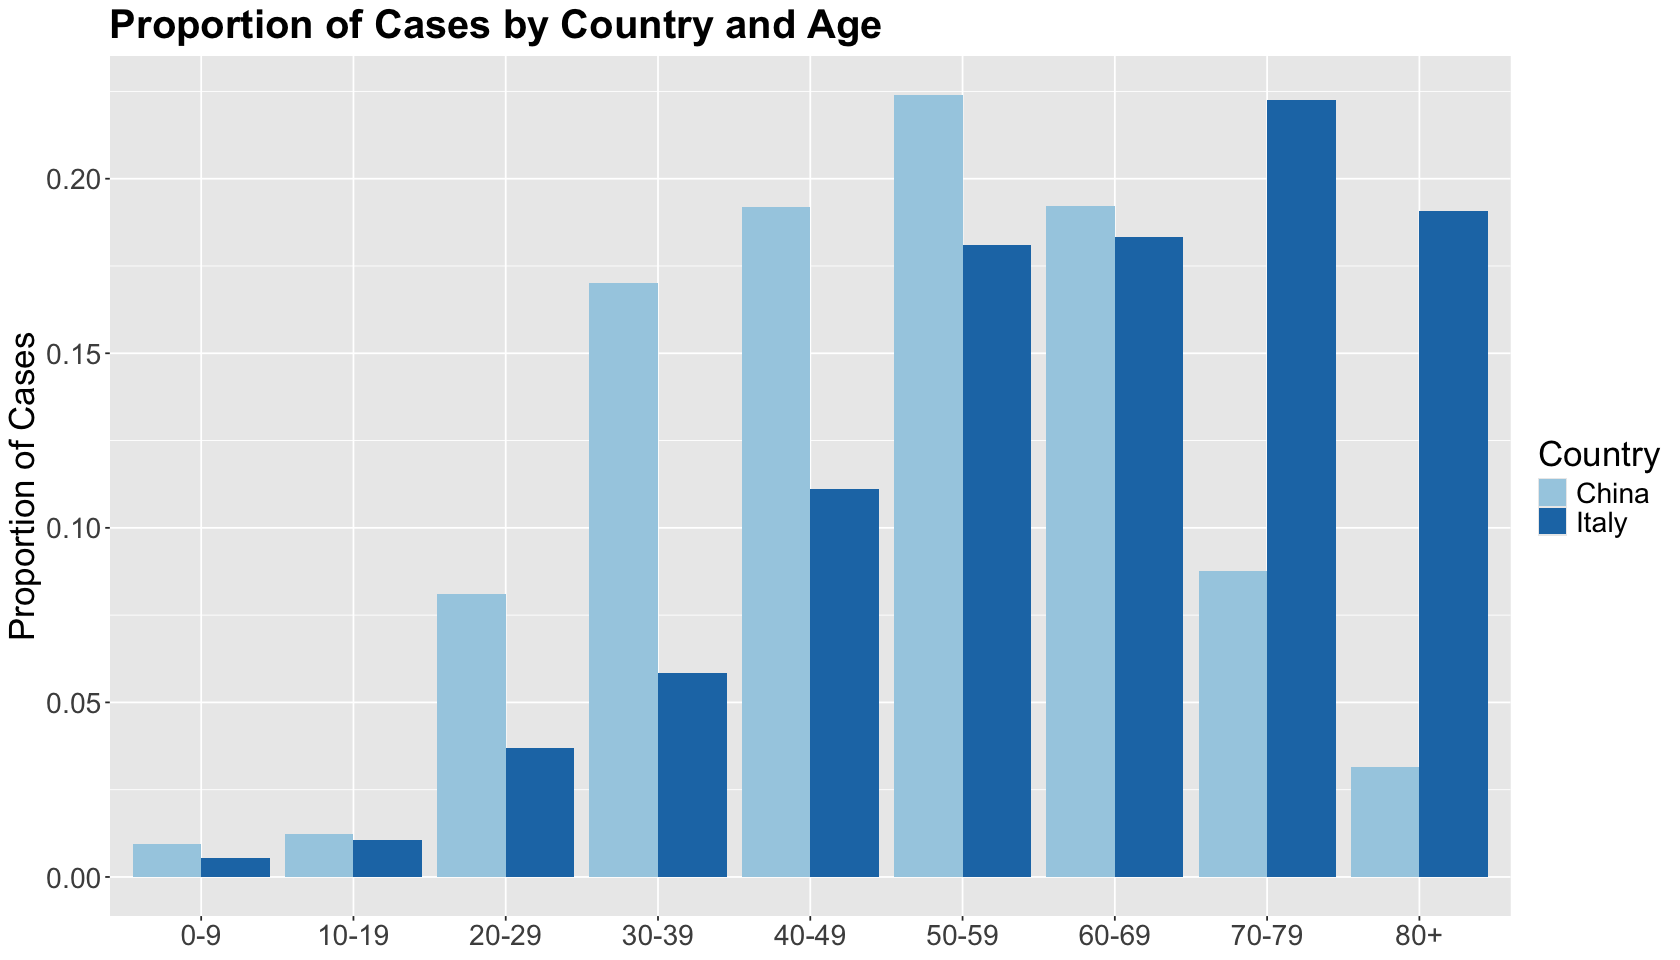

In [20]:
hist_covid19_perc_by_country_and_age

Moreover, the literature has addressed another fact: **higher age is correlated with higher fatality rates for COVID-19 cases**. There is strong scientific evidence that this correlation is **causal**. We might say that age is a **confounder** of the country-COVID fatality rate relationship.

The correlation coefficients below come from the age groups by country between case fatality rate and proportion of cases. China's cases are mostly younger than Italy's cases, hence its negative coefficient.

In [21]:
covid19_data_perc_by_country_and_age %>%
  group_by(Country) %>%
  dplyr::summarise(corr = round(cor(`Fatality rate`, `Proportion of cases`), 2))

Country,corr
<chr>,<dbl>
China,-0.26
Italy,0.63


### 1.3.  How to Avoid Misleading Conclusions

Let us focus on the COVID-19 data. Suppose you are doing your analysis with the **overall case fatality rates** between China and Italy. One might be tempted to say that **"Italy did a bad job treating its COVID-19 compared to China."** Nevertheless, you would miss another important variable which is **age**.

If Italy has a larger proportion of cases in older age groups, compared to China, and other literature has already addressed that older people are more prone to COVID-19 fatalities, then the previous statement is misleading! **You would be falling into the Simpson's paradox trap!**

```{caution}
To avoid misleading conclusions, it is **extremely important** to know how our data was collected. Moreover, even before collecting any data, we need to define what variables are relevant to our study. For example, if we want to infer causality, we must determine the possible causes for our outcome of interest.

**We cannot start collecting data if we do not carefully design our sampling plan!**
```

## 2. Two Big-Picture Strategies for Dealing With Confounding

We will introduce the concept of confounders and their role in causal inference when performing **observational AND experimental studies** such as **randomized clinical trials (RCTs)** or **A/B testings**.

We will do this exercise via different simulations with OLS.

But first, let us start by formally explaining what a *confounder* is. [Mann and Wood (2012)](https://benthamopen.com/contents/pdf/TOEPIJ/TOEPIJ-5-18.pdf) provide the following definition in a medical context:

> *In general, for a variable to be a confounder in a particular study, the formal definition requires that it must meet two criteria: the first is that it must be related to the outcome of interest in terms of prognosis or
susceptibility. The second criteria, which explains why it is more commonly seen outside the setting of RCTs, is that the distribution of the confounding factor is different in the groups being compared. More broadly, confounding can be defined as a mixing of effects between the **exposure of interest**, the **disease**, and a third factor (i.e., the **confounder**) that is associated with the **exposure** that independently affects the risk of developing the **disease**.*

The previous definition might sound too wordy. Thus, by using our aforementioned Simpson paradox's example, let us untangle the elements of confounding:

- **Exposure of interest.** A specific country (China or Italy) that could involve environmental conditions, health infrastructure, etc.
- **Disease.** COVID-19  via its case fatality rate.
- **Confounder.** Age group.

Roughly speaking, in a regresssion framework where $X$ is the regressor and $Y$ is the response, another regressor $C$ confounds the $X$-$Y$ relationship if $C$ and $X$ are associated, and $C$ and $Y$ are associated as shown in {numref}`confounding`.

```{figure} ../img/confounding.png
:height: 300px
:name: confounding

Diagram of Confounding.
```

### 2.1. The TikTok® Simulation

> *Copyright © 2025 TikTok*
> 
You are part of a team of data scientists working for a given company. The team is in charge of an A/B testing involving a TikTok® ad. The case study's framework is the following:

```{admonition} Main statistical inquiry

Suppose the company's marketing team has developed a new ad for TikTok®. They want to know if this **NEW AD** will **INCREASE** the ad engagement (which they will measure via the **ad dwell time** in seconds) compared to the **CURRENT AD** they are running in a given customer population.

Furthermore, let us make the framework more complex. Suppose your customer population is located in two cities: **Vancouver** and **Victoria**. Moreover, **customers from Victoria have larger dwell times**. The dwell times also increase in **older** customers **regardless of their city**.
```

```{exercise}
:label: lecture2-q1

Under this framework, what is the response $Y$?

**A.** Customer's age.

**B.** City.

**C.** Ad dwell time.

**D.** Type of TikTok® ad.
```

```{exercise}
:label: lecture2-q2

Under this framework, what is the main regressor of interest $X$?

**A.** Customer's age.

**B.** City.

**C.** Ad dwell time.

**D.** Type of TikTok® ad.
```

```{exercise}
:label: lecture2-q3

Under this framework, what regressors are the confounders $C_1$ and $C_2$?

**A.** Customer's age.

**B.** City.

**C.** Customer's age and city. 
```

### 2.2. The Strategies

There is more than one way to deal with confounding if we want to detect a causal relationship between $X$ and $Y$. Depending on the nature of the study, one could do the following:

1. In the case of observational studies, **stratification** is a good strategy. It implies checking the association between $X$ and $Y$ within subgroups of observations that share common values for the confounders. In a linear regression context with $m$ confounders $C_j$, we would regress $Y$ on $X$ **and** $C_1, C_2, \dots, C_m$.

2. In an experimental study, such as A/B testing, we would randomize each subject to a particular level of factor $X$. Then, we compare $Y$ across the different levels of $X$. For instance, one could use an **Analysis of Variance (ANOVA)**, which is just one specific class of OLS model (**a continuous response versus a categorical and nominal regressor**).

```{important}
The second strategy is the golden standard in causal inference and design and analysis of experiments. Nonetheless, it might implicate different statistical, practical, and ***ETHICAL*** matters.
```

```{admonition} What is the beauty of a randomized experiment?
:class: hint
The regressor $X$ is **guaranteed** to be independent of all possible confounders! Whether or not you can measure these confounders, or even know the identity of each $C_j$.

Thus, we no longer need to be concerned with confounding, and **we can interpret the association between $X$ and $Y$ in a causal manner**.
```

### 2.3. Building a Synthetic Population

Before approaching the previous two strategies, let us build our synthetic population for the TikTok® ad case.

Suppose this population has `1000000` customers (`pop.size`), where 50% are from `Victoria` and the other 50% are from `Vancouver` (i.e., a regressor called `city`). Moreover, let us assume that the regressor `age` is **uniformly distributed** across the whole customer population **between 16 and 24 years old**.

The code below builds a tibble containing all the customers in the population called `pop.pool` with two columns: one for `city` and another for `age`. As explained above, the values in these two columns need to be simulated.

In [22]:
set.seed(554) # Reproducibility

pop.size <- 1000000

pop.pool <- tibble(
  city = sample(c(rep("Vancouver", pop.size / 2), rep("Victoria", pop.size / 2))),
  age = runif(pop.size, 16, 24) # Random number generator from uniform distribution
)
pop.pool

city,age
<chr>,<dbl>
Victoria,20.30095
Victoria,23.53586
Victoria,19.09438
Vancouver,19.51355
⋮,⋮
Vancouver,23.98407
Vancouver,18.06687
Vancouver,22.71233
Victoria,16.74671


Once we have our synthetic population pool of customers, we need to simulate their corresponding **dwell times** $Y$ if they see the **current** or the **new ad**. Hence, each customer in the population will have their pair of **potential responses**: one for the **current ad** and one for the **new ad** in seconds.

```{caution}
Everyone has a potential response that will manifest if they watch the current **OR** new ad.
```

Within the population, both responses will have their own means **per customer** as follows:

In [23]:
mean_current_ad <- 15 + 5 * (pop.pool$city == "Victoria") + 0.2 * pop.pool$age
round(head(mean_current_ad), 4)

mean_new_ad <- mean_current_ad + 8
round(head(mean_new_ad), 4)

[1] 24.0602 24.7072 23.8189 18.9027 19.0822 23.9516

[1] 32.0602 32.7072 31.8189 26.9027 27.0822 31.9516

The previous code is computing response means in seconds for each customer within `pop.pool`, according to their specific values in `city` and `age`, and storing them in two vectors:

- `mean_current_ad`: This is the vector of `1000000` response means corresponding to the **current** video. It has a baseline of `15` seconds for each customer, plus `5` additional seconds if the customer is from `Victoria`, and `0.2` seconds per year in `age` regardless of where the customer is located.
- `mean_new_ad`: This is the vector of `1000000` response means corresponding to the **new** video. It is just the vector `mean_current_ad` plus `8` seconds for **ALL** the customers.

```{attention}
Note that the value of `8` in `mean_new_ad` is the one we aim to estimate via an **observational** or **experimental** study, which denotes that the **new** ad increases the dwell time by 8 seconds for the customer population **in general**. The effect **`8` seconds** refers to our **main statistical inquiry**!
```

Once we have these vectors of means, we can simulate the corresponding responses `y_current_ad` and `y_new_ad` and incorporate them in `pop.pool` as two new columns. These responses will be **normally distributed** (i.e., `rnorm()`) with means `mean_current_ad` and `mean_new_ad` and fixed standard deviations of 1 second.


In [24]:
set.seed(554) # Reproducibility

pop.pool$y_current_ad <- rnorm(pop.size, mean = mean_current_ad, sd = 1)
pop.pool$y_new_ad <- rnorm(pop.size, mean = mean_new_ad, sd = 1)

pop.pool

city,age,y_current_ad,y_new_ad
<chr>,<dbl>,<dbl>,<dbl>
Victoria,20.30095,24.87506,29.23864
Victoria,23.53586,23.84210,32.29992
Victoria,19.09438,23.78396,33.55232
Vancouver,19.51355,17.20327,27.84733
⋮,⋮,⋮,⋮
Vancouver,23.98407,18.85700,28.33902
Vancouver,18.06687,18.83784,26.85744
Vancouver,22.71233,19.44461,27.68320
Victoria,16.74671,22.46434,31.84106


### 2.4. Study 1: Observational and Naive

Let us suppose we run a naive observational study. In this case, we will obtain a sample of customers. They will be able to choose the ad they want to see (i.e., we just conduct an **observational study**).

The upcoming code will create a factor-type column called `x_self_choice` with:

- the value of `1` (relabeled to level `New Ad`), denoting that the customer in `pop.pool` (**if observed**) would choose to watch the **new** ad, and 
- `0` (relabeled to level `Current Ad`) for the **current** ad. 

These values are random numbers coming from a **Bernoulli distribution** (`rbinom()` with `size = 1`) whose probability of success (i.e., choosing the **new** ad) increases when the customer is from `Victoria` while slightly decreasing for older customers **in general** (check argument `prob` in `rbinon()`).

In [25]:
set.seed(554) # Reproducibility

pop.pool$x_self_choice <- as.factor(rbinom(pop.size,
  size = 1,
  prob = 0.5 + 0.5 * (pop.pool$city == "Victoria") - 0.005 * pop.pool$age
))
pop.pool$x_self_choice <- fct_recode(pop.pool$x_self_choice, "Current Ad" = "0", "New Ad" = "1")
pop.pool

city,age,y_current_ad,y_new_ad,x_self_choice
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Victoria,20.30095,24.87506,29.23864,New Ad
Victoria,23.53586,23.84210,32.29992,New Ad
Victoria,19.09438,23.78396,33.55232,New Ad
Vancouver,19.51355,17.20327,27.84733,Current Ad
⋮,⋮,⋮,⋮,⋮
Vancouver,23.98407,18.85700,28.33902,Current Ad
Vancouver,18.06687,18.83784,26.85744,New Ad
Vancouver,22.71233,19.44461,27.68320,New Ad
Victoria,16.74671,22.46434,31.84106,New Ad


Next, we will create another column in `pop.pool` called `y_obs`, which will contain the observed response by customer based on `x_self_choice`; i.e., **IF** the customer is more likely to choose the `New Ad` then the column `y_obs` will contain the value indicated in `y_new_ad`, **ELSE** otherwise. Then, from `pop.pool`, we will collect one sample of size `1000` and call it `sample_TikTok`.

In [26]:
set.seed(554) # Reproducibility

pop.pool$y_obs <- ifelse(pop.pool$x_self_choice == "Current Ad",
  pop.pool$y_current_ad, pop.pool$y_new_ad
)

sample_TikTok <- rep_sample_n(pop.pool, size = 1000)
sample_TikTok

replicate,city,age,y_current_ad,y_new_ad,x_self_choice,y_obs
<int>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Victoria,22.39433,23.08302,31.46239,New Ad,31.46239
1,Vancouver,22.37157,20.96466,26.64890,New Ad,26.64890
1,Vancouver,20.36378,19.25500,27.85650,New Ad,27.85650
1,Vancouver,16.82234,17.78648,26.91782,New Ad,26.91782
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,Victoria,19.70080,24.77803,32.58291,New Ad,32.58291
1,Victoria,20.65071,25.03055,31.85587,New Ad,31.85587
1,Vancouver,19.75119,19.86671,26.47666,New Ad,26.47666
1,Victoria,23.58678,24.31605,31.36179,New Ad,31.36179


In [27]:
table(sample_TikTok$x_self_choice) # Choices in observed sample (n = 1000)


Current Ad     New Ad 
       343        657 

#### 2.4.1. Exploratory Data Analysis

We must graphically compare the observed distributions and spread in both ads within `sample_TikTok` via side-by-side boxplots. We also include the sample average by **type of ad** (as a yellow point): `Current Ad` and `New Ad`. The EDA shows larger dwell times for the `New Ad`.

In [28]:
obs_dwell_time_boxplots <- sample_TikTok %>%
  ggplot(aes(x_self_choice, y_obs)) +
  geom_violin(aes(fill = x_self_choice)) + 
  geom_boxplot(width = 0.15) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) +
  ggtitle("Dwell Times (Naive Observational)") +
  xlab("Type") +
  ylab("Dwell Time (seconds)") +
  guides(fill = "none") +
  stat_summary(aes(x_self_choice, y_obs, fill = x_self_choice),
    fun = mean, colour = "orange", geom = "point",
    shape = 18, size = 7
  ) +
  scale_fill_brewer(palette = "Paired")

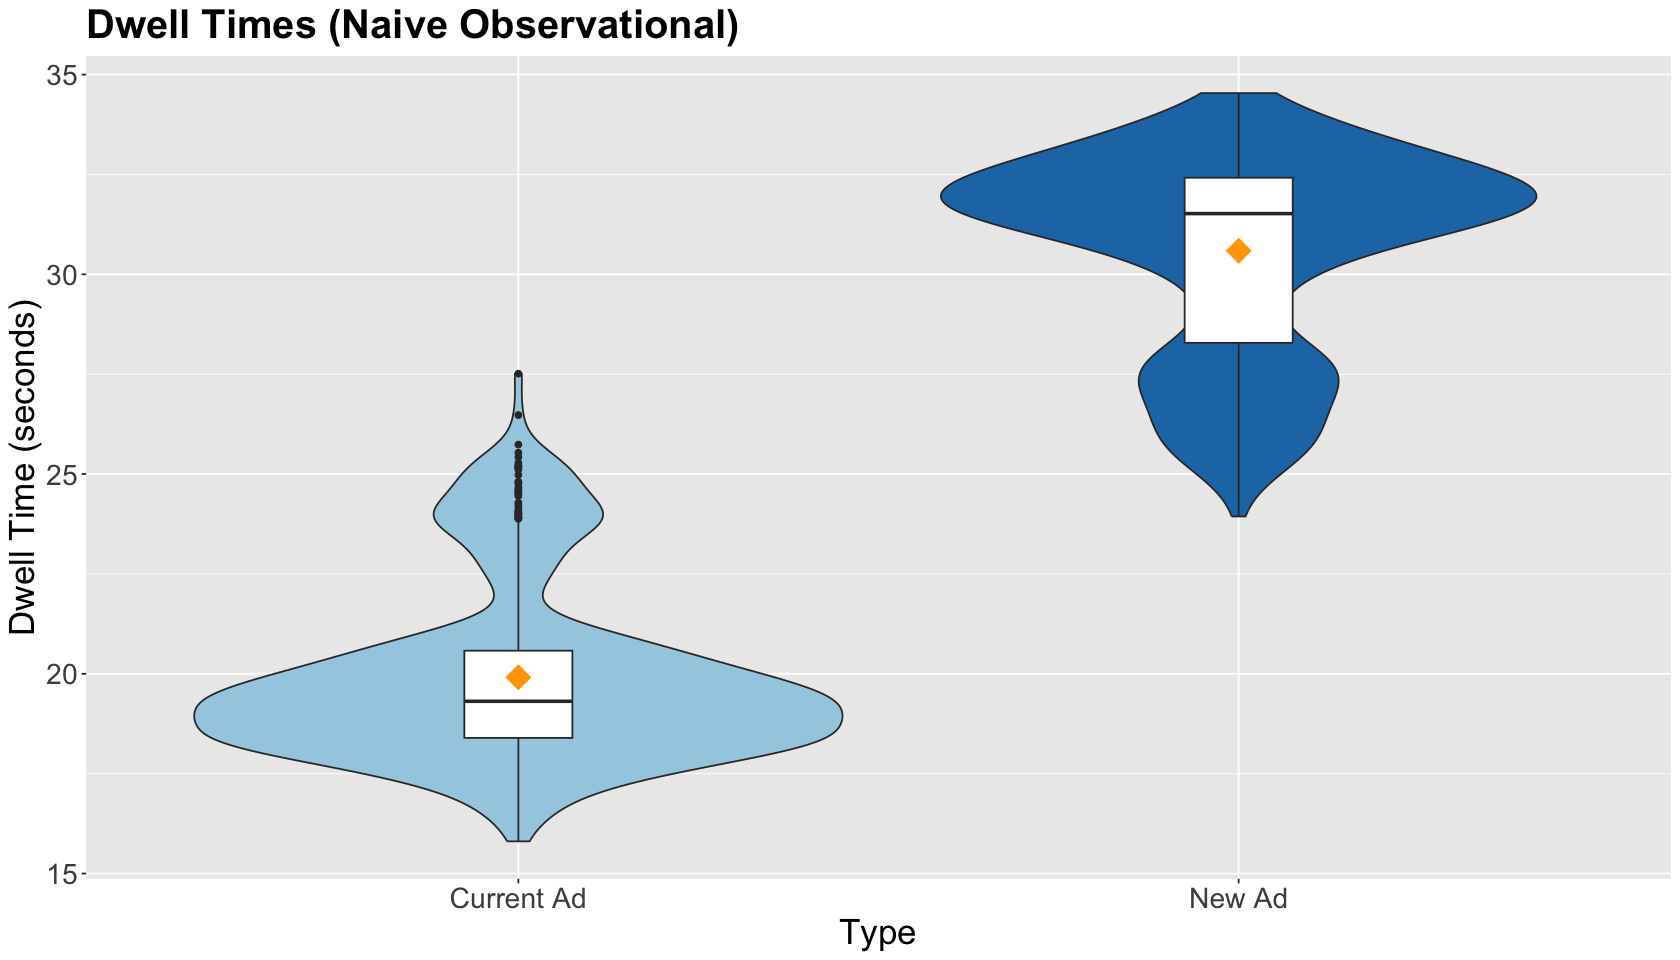

In [29]:
obs_dwell_time_boxplots

#### 2.4.2. Regression Model

Imagine that we only collect the dwell times and the type of chosen ad (as shown below) in `sample_TikTok`. Suppose you want to estimate the **real population effect** in the dwell time of the new ad compared to the current ad. **Recall we set up our synthetic data so this effect is an increase of 8 seconds IN GENERAL.**

In [30]:
sample_TikTok[, c("x_self_choice", "y_obs")]

x_self_choice,y_obs
<fct>,<dbl>
New Ad,31.46239
New Ad,26.64890
New Ad,27.85650
New Ad,26.91782
⋮,⋮
New Ad,32.58291
New Ad,31.85587
New Ad,26.47666
New Ad,31.36179


Using `sample_TikTok`, we estimate an OLS model called `OLS_naive_obs_study_TikTok` of the dwell time (`y_obs`) versus the chosen type of ad (`x_self_choice`). We include the corresponding asymptotic 95% confidence intervals (CIs) in our model's summary. **This is an ANOVA model.**

In [31]:
OLS_naive_obs_study_TikTok <- lm(y_obs ~ x_self_choice,
  data = sample_TikTok
)

OLS_naive_obs_study_TikTok_results <- tidy(OLS_naive_obs_study_TikTok, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
OLS_naive_obs_study_TikTok_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),19.91,0.13,151.68,0,19.66,20.17
x_self_choiceNew Ad,10.68,0.16,65.92,0,10.36,10.99


Note the estimated effect in dwell time, when switching from the current to the new ad, **increases by 10.68 seconds** and is statistically significant. **The effect is clearly overestimated in this analysis, even when computing the 95% CI!**

```{exercise}
:label: lecture2-q4

Why are we overestimating the effect of the new ad in this naive observational study?
```

### 2.5. Study 2: Observational and Less Naive

Now, let us suppose we ran a less naive study when collecting `sample_TikTok`. Hence, we also record the values of the confounders `city` and `age` when running our study.

In [32]:
sample_TikTok[, c("city", "age", "x_self_choice", "y_obs")]

city,age,x_self_choice,y_obs
<chr>,<dbl>,<fct>,<dbl>
Victoria,22.39433,New Ad,31.46239
Vancouver,22.37157,New Ad,26.64890
Vancouver,20.36378,New Ad,27.85650
Vancouver,16.82234,New Ad,26.91782
⋮,⋮,⋮,⋮
Victoria,19.70080,New Ad,32.58291
Victoria,20.65071,New Ad,31.85587
Vancouver,19.75119,New Ad,26.47666
Victoria,23.58678,New Ad,31.36179


We estimate another OLS model called `OLS_obs_study_TikTok` of the dwell time (`y_obs`) versus the type of ad and the respective confounders.

In [33]:
OLS_obs_study_TikTok <- lm(y_obs ~ x_self_choice + city + age,
  data = sample_TikTok
)

OLS_obs_study_TikTok <- tidy(OLS_obs_study_TikTok, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
OLS_obs_study_TikTok

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),15.34,0.28,54.53,0,14.79,15.89
x_self_choiceNew Ad,8.03,0.08,103.48,0,7.87,8.18
cityVictoria,5.02,0.07,68.12,0,4.88,5.17
age,0.18,0.01,13.21,0,0.15,0.21


Note the estimated effect in dwell time, when switching from the current to the new ad, **increases by 8.03 seconds** and is statistically significant. Controlling for these causal covariates (confounders!), we get an accurate estimate for the effect of the new ad! We also have accurate estimates for `city` and `age` given how we created our artificial population.

### 2.6. Study 3: Randomized Study (Gold Standard)

Finally, suppose we can run an experimental study (i.e., **a TikTok A/B testing**) with the customers in `sample_TikTok` **under a balanced design** (i.e., we allocate equal numbers of subjects by **experimental treatment**).

Therefore, we create a two-level factor-type column called `x_randomized` by randomly assign each customer to view either the `Current Ad` or the `New Ad`. Then, we create another column in `sample_TikTok` called `y_exp`, which will contain the obtained experimental response by customer based on `x_randomized`; i.e., if the customer is assigned to `New Ad` then the column `y_exp` will contain the value indicated in the **potential** `y_new_ad`, else otherwise.

In [34]:
set.seed(1234) # Reproducibility

sample_TikTok$x_randomized <- sample(c(
  rep("Current Ad", nrow(sample_TikTok) / 2),
  rep("New Ad", nrow(sample_TikTok) / 2)
))
sample_TikTok$y_exp <- ifelse(sample_TikTok$x_randomized == "Current Ad",
  sample_TikTok$y_current_ad, sample_TikTok$y_new_ad
)
sample_TikTok

replicate,city,age,y_current_ad,y_new_ad,x_self_choice,y_obs,x_randomized,y_exp
<int>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<dbl>
1,Victoria,22.39433,23.08302,31.46239,New Ad,31.46239,Current Ad,23.08302
1,Vancouver,22.37157,20.96466,26.64890,New Ad,26.64890,New Ad,26.64890
1,Vancouver,20.36378,19.25500,27.85650,New Ad,27.85650,New Ad,27.85650
1,Vancouver,16.82234,17.78648,26.91782,New Ad,26.91782,Current Ad,17.78648
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,Victoria,19.70080,24.77803,32.58291,New Ad,32.58291,Current Ad,24.77803
1,Victoria,20.65071,25.03055,31.85587,New Ad,31.85587,New Ad,31.85587
1,Vancouver,19.75119,19.86671,26.47666,New Ad,26.47666,Current Ad,19.86671
1,Victoria,23.58678,24.31605,31.36179,New Ad,31.36179,Current Ad,24.31605


#### 2.6.1. Exploratory Data Analysis

Before fitting the corresponding regression, let us compare the side-by-side boxplots of the naive observational study versus the experimental study. The treatment means are closer in the experimental study, and treatment data spread is graphically quite similar.

In [35]:
exp_dwell_time_boxplots <- sample_TikTok %>%
  ggplot(aes(x_randomized, y_exp)) +
  geom_violin(aes(fill = x_randomized)) + 
  geom_boxplot(width = 0.15) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) +
  ggtitle("Dwell Times (Experimental)") +
  xlab("Type") +
  ylab("Dwell Time (seconds)") +
  guides(fill = "none") +
  stat_summary(aes(x_randomized, y_exp, fill = x_randomized),
    fun = mean, colour = "orange", geom = "point",
    shape = 18, size = 7
  ) +
  scale_fill_brewer(palette = "Paired")

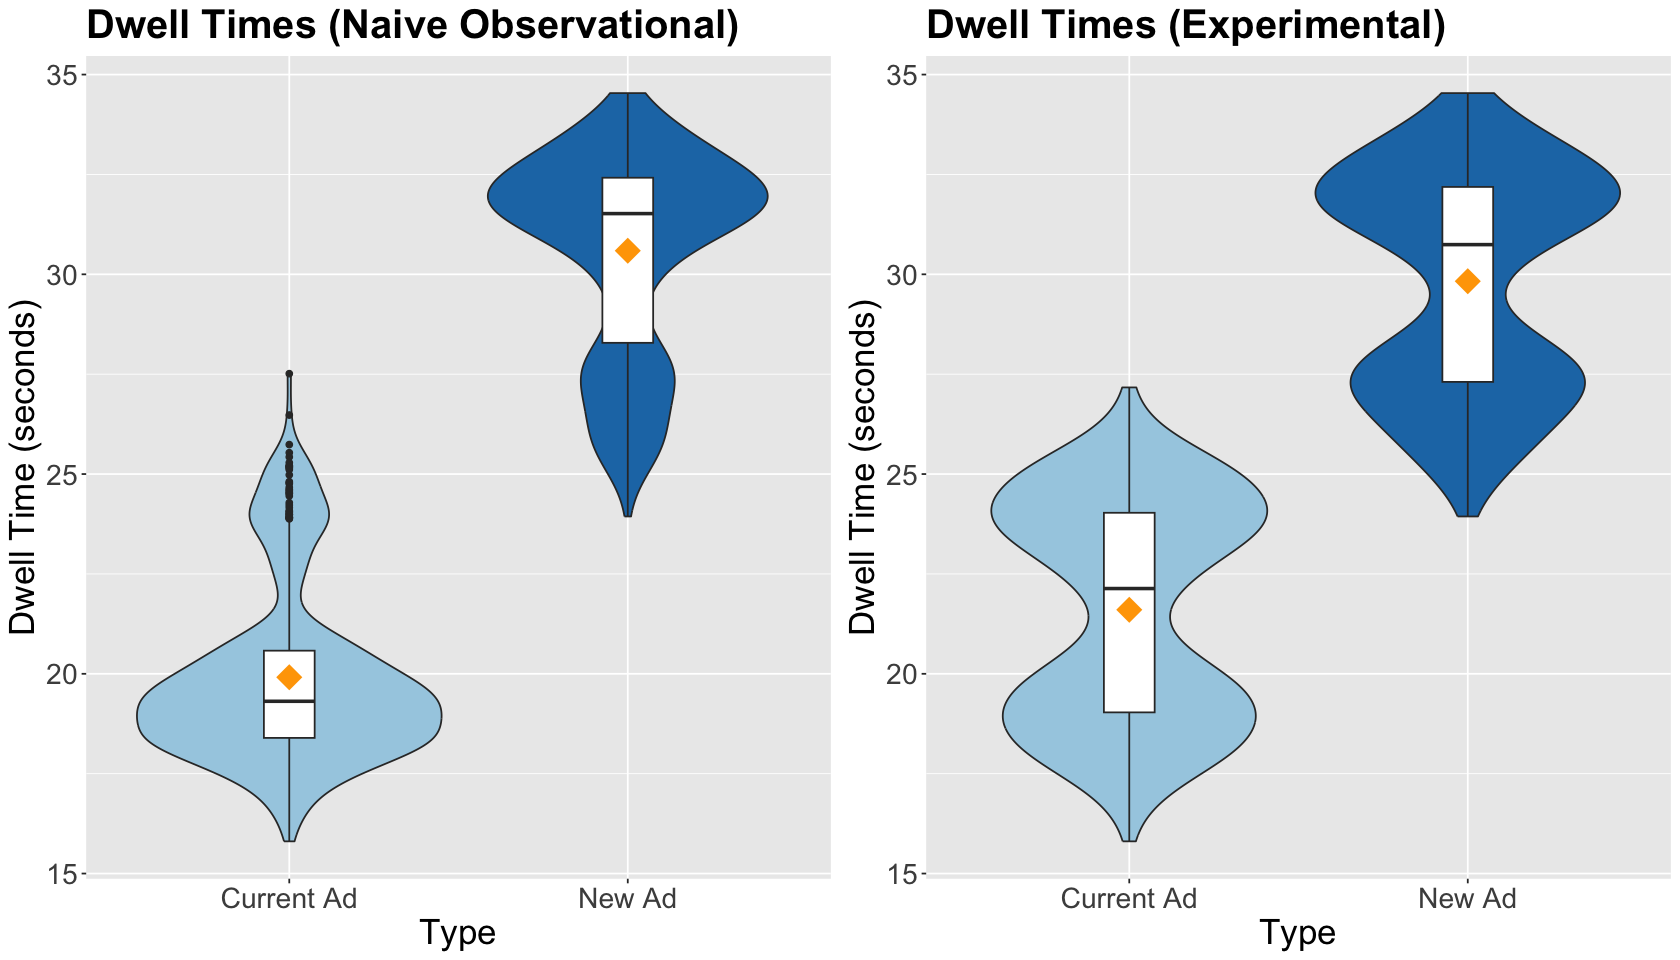

In [36]:
plot_grid(obs_dwell_time_boxplots, exp_dwell_time_boxplots)

#### 2.6.2. Regression Model

Finally, we estimate another OLS model called `OLS_exp_study_TikTok` of the experimental dwell time (`y_exp`) versus the assigned type of ad (`x_randomized`). **This is an ANOVA model.**

In [37]:
OLS_exp_study_TikTok <- lm(y_exp ~ x_randomized,
  data = sample_TikTok
)

OLS_exp_study_TikTok_results <- tidy(OLS_exp_study_TikTok, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
OLS_exp_study_TikTok_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),21.60,0.12,174.77,0,21.36,21.85
x_randomizedNew Ad,8.22,0.17,47.05,0,7.88,8.57


In [38]:
OLS_naive_obs_study_TikTok_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),19.91,0.13,151.68,0,19.66,20.17
x_self_choiceNew Ad,10.68,0.16,65.92,0,10.36,10.99


Note the **estimated experimental effect** in dwell time, when switching from the current to the new ad, **increases by 8.22 seconds** and is statistically significant. Right on! According to the output above, we obtain more accurate estimations with a randomized study than a naive observational one.

Nevertheless, compared to the less naive observational study, **the 95% CI of the effect estimate is less precise!**

In [39]:
OLS_obs_study_TikTok

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),15.34,0.28,54.53,0,14.79,15.89
x_self_choiceNew Ad,8.03,0.08,103.48,0,7.87,8.18
cityVictoria,5.02,0.07,68.12,0,4.88,5.17
age,0.18,0.01,13.21,0,0.15,0.21


In [40]:
OLS_exp_study_TikTok_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),21.60,0.12,174.77,0,21.36,21.85
x_randomizedNew Ad,8.22,0.17,47.05,0,7.88,8.57


We can have a more precise effect estimate if we include `city` and `age` as in the experimental OLS model below.

In [41]:
OLS_full_exp_study_TikTok <- lm(y_exp ~ x_randomized + city + age,
  data = sample_TikTok
)

OLS_full_exp_study_TikTok_results <- tidy(OLS_full_exp_study_TikTok, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
OLS_full_exp_study_TikTok_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),15.20,0.27,55.31,0,14.66,15.74
x_randomizedNew Ad,8.04,0.06,128.36,0,7.91,8.16
cityVictoria,5.08,0.06,80.97,0,4.96,5.20
age,0.19,0.01,13.91,0,0.16,0.21


Note the estimated effect in dwell time, when switching from the current to the new ad, **increases by 8.04 seconds** and is statistically significant. The model above is as precise as the less naive observational model.

In [42]:
OLS_obs_study_TikTok

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),15.34,0.28,54.53,0,14.79,15.89
x_self_choiceNew Ad,8.03,0.08,103.48,0,7.87,8.18
cityVictoria,5.02,0.07,68.12,0,4.88,5.17
age,0.18,0.01,13.21,0,0.15,0.21


From the previous results, we get similar estimates. Hence, we might wonder: **why are we running an experiment when we can only execute a less naive observational study?**

In this example, we know exactly how the synthetic population is structured. Therefore, we know what confounders to use in our observational OLS model. Nonetheless, in real life, different populations would get extremely complex with a whole set of counfounders. **Identifying and measuring the right confounders is another complex sampling task.**

Again, the beauty of randomized experiments (such as A/B testing) allows the **accurate estimation** of our experimental effect of interest without including confounders. But, of course, we can include some confounders in our experimental OLS, making our estimations **more precise**.

In this specific example, our second experimental OLS (`OLS_full_exp_study_TikTok`) has the following experimental components:

- The **continuous response** `y_exp`.
- The **experimental factor of interest** `x_randomized` with two **treatments**: `New Ad` and `Current Ad`.
- A categorical **variable** `city` with two levels: `Victoria` and `Vancouver`. 
- A continuous **covariate** `age`.

These elements make our OLS model an **Analysis of Covariance (ANCOVA)**.

## 3. Wrapping Up

We have covered a lot of ground:

- The Simpson's paradox and its relation with confounding (how to avoid this paradox).
- Randomized experiments versus observational studies:
  - Accuracy of inference via proper regression modelling.
  - Proper validity of causal claims with the right variables.